In [ ]:
#default_exp model.RT

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2

In [ ]:
#export
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm

from alphadeep.model.featurize import \
    parse_aa_indices, \
    get_batch_mod_feature

from alphadeep._settings import model_const

import alphadeep.model.base as model_base


mod_feature_size = len(model_const['mod_elements'])


In [ ]:
#export
class EncDecModelRT(torch.nn.Module):
    def __init__(self, 
        mod_feature_size,
        dropout=0.2
    ):
        super().__init__()
        self.aa_embedding_size = 27
        
        self.dropout = torch.nn.Dropout(dropout)
        
        hidden = 256
        self.encoder = model_base.SeqEncoder(
            self.aa_embedding_size+mod_feature_size, 
            hidden,
            dropout=0,
            rnn_layer=2
        )

        self.decoder = model_base.LinearDecoder(
            hidden,
            1
        )

    def forward(self, 
        aa_indices, 
        mod_x,
    ):
        aa_x = torch.nn.functional.one_hot(
            aa_indices, self.aa_embedding_size
        )

        x = torch.cat((aa_x, mod_x), 2)
        x = self.encoder(x)
        x = self.dropout(x)

        return self.decoder(x).squeeze(1)

In [ ]:
#export
class AlphaRTModel(model_base.ModelImplBase):
    def __init__(self, dropout=0.2, lr=0.001):
        super().__init__()
        self.build(
            EncDecModelRT, lr=lr, 
            dropout=dropout, 
            mod_feature_size=mod_feature_size
        )
        self.loss_func = torch.nn.L1Loss()
    
    def train(self, 
        precursor_df: pd.DataFrame,
        epoch=10,
        batch_size=1024,
        verbose=False,
        verbose_each_epoch=False,
    ):
        self.model.train()

        for epoch in range(epoch):
            batch_cost = []
            _grouped = list(precursor_df.sample(frac=1).groupby('nAA'))
            rnd_nAA = np.random.permutation(len(_grouped))
            if verbose_each_epoch:
                batch_tqdm = tqdm(rnd_nAA)
            else:
                batch_tqdm = rnd_nAA
            for i_group in batch_tqdm:
                nAA, df_group = _grouped[i_group]
                df_group = df_group.reset_index(drop=True)
                for i in range(0, len(df_group), batch_size):
                    batch_end = i+batch_size-1 # DataFrame.loc[start:end] inlcudes the end

                    aa_indices = torch.LongTensor(
                        parse_aa_indices(
                            df_group.loc[i:batch_end, 'sequence'].values.astype('U')
                        )
                    )

                    mod_x_batch = get_batch_mod_feature(df_group.loc[i:batch_end,:], nAA)
                    mod_x = torch.Tensor(mod_x_batch)

                    RTs = torch.Tensor(df_group.loc[i:batch_end,'RT'].values)

                    cost = self._train_one_batch(
                        RTs,
                        aa_indices, mod_x
                    )
                    batch_cost.append(cost.item())
                if verbose_each_epoch:
                    batch_tqdm.set_description(
                        f'Epoch={epoch+1}, nAA={nAA}, Batch={len(batch_cost)}, Loss={cost.item():.4f}'
                    )
            if verbose: print(f'[MS/MS training] Epoch={epoch+1}, Mean Loss={np.mean(batch_cost)}')

    def predict(self, precursor_df, batch_size=1024, verbose=False):
        self.model.eval()

        precursor_df['predict_RT'] = 0

        _grouped = precursor_df.groupby('nAA')
        df_list = []
        if verbose:
            batch_tqdm = tqdm(_grouped)
        else:
            batch_tqdm = _grouped
        for nAA, df_group in batch_tqdm:
            df_group = df_group.reset_index(drop=True)
            for i in range(0, len(df_group), batch_size):
                batch_end = i+batch_size-1 # DataFrame.loc[start:end] inlcudes the end

                mod_x_batch = get_batch_mod_feature(df_group.loc[i:batch_end,:], nAA)

                aa_indices = torch.LongTensor(parse_aa_indices(
                    df_group.loc[i:batch_end, 'sequence'].values.astype('U')
                ))
                mod_x = torch.Tensor(mod_x_batch)

                predicts = self.model(
                    *[fea.to(self.device) for fea in
                    [aa_indices, mod_x]
                ]).cpu().detach().numpy()

                predicts[predicts<0] = 0

                df_group.loc[i:batch_end, 'predict_RT'] = predicts
            df_list.append(df_group)

        return pd.concat(df_list).reset_index(drop=True)

In [ ]:
model = AlphaRTModel()
model.device = torch.device('cpu')
model.model.to(model.device)
model.model(torch.LongTensor([[1,2,3,4,5,6]]), torch.tensor([[[0.0]*8]*6]))

tensor([0.0373], grad_fn=<SqueezeBackward1>)

In [ ]:
model.model

EncDecModelRT(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): SeqEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (input_cnn): SeqCNN(
      (cnn_short): Conv1d(35, 35, kernel_size=(3,), stride=(1,), padding=(1,))
      (cnn_medium): Conv1d(35, 35, kernel_size=(5,), stride=(1,), padding=(2,))
      (cnn_long): Conv1d(35, 35, kernel_size=(7,), stride=(1,), padding=(3,))
    )
    (hidden_nn): SeqLSTM(
      (rnn): LSTM(140, 128, num_layers=2, batch_first=True, bidirectional=True)
    )
    (attn_sum): SeqAttentionSum(
      (attn): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=False)
        (1): Softmax(dim=1)
      )
    )
  )
  (decoder): LinearDecoder(
    (nn): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#export
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_linear_regression(df, x='predict_RT', y='RT', ci=0.95):
    gls = sm.GLS(df[y], sm.add_constant(df[x]))
    res = gls.fit()
    summary = res.summary(alpha=1-ci)
    return summary

def evaluate_linear_regression_plot(df, x='predict_RT', y='RT', ci=95):
    sns.regplot(data=df, x=x, y=y, color='r', ci=ci, scatter_kws={'s':0.05, 'alpha':0.05, 'color':'b'})
    plt.show()

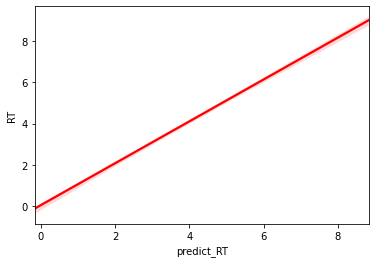

In [ ]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'RT':np.arange(10), 'predict_RT':np.arange(10)+np.random.normal(0,0.3,10)})
evaluate_linear_regression_plot(df)